In [22]:
import argparse
import datetime
import json
import os
import shutil

import numpy as np
import torch
import torch.utils.data as udata
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import tqdm
import torch.nn as nn

import sys 
import pandas as pd
from PIL import Image
#from tqdm import tqdm
from torchsummary import summary
import pdb
import yaml
from utils import read_data_file, load_images_and_labels,inverse_image,make3d,unstack,save_images
from torch.autograd import Variable
import utils_sngan as utils_sngan
import math
from torch.nn import init
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
config = 'configs/celebA_Young_Explainer.yaml'
config = yaml.load(open(config))
print(config)

{'image_label_dict': './output/classifier/CelebA-Young/explainer_input/list_attr_celeba_Young.txt', 'cls_experiment': './output/classifier/CelebA-Young', 'log_dir': './output/explainer', 'name': 'CelebA-Young-Binary', 'num_channel': 3, 'num_class': 2, 'num_bins': 10, 'target_class': 1, 'input_size': 128, 'batch_size': 32, 'epochs': 300, 'lambda_GAN': 1, 'lambda_cyc': 100, 'lambda_cls': 1, 'save_summary': 20, 'ckpt_dir_continue': './output/explainer/CelebA-Young-Binary', 'count_to_save': 20}


/pylon5/ac5616p/debdas/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [3]:
assets_dir = os.path.join('.'+config['log_dir'], config['name'])
log_dir = os.path.join(assets_dir, 'log')
ckpt_dir = os.path.join(assets_dir, 'ckpt_dir')
sample_dir = os.path.join(assets_dir, 'sample')
test_dir = os.path.join(assets_dir, 'test')

ckpt_dir_cls = '.'+ config['cls_experiment']   
BATCH_SIZE = config['batch_size']
EPOCHS = config['epochs']
channels = config['num_channel']
input_size = config['input_size'] 
NUMS_CLASS_cls = config['num_class']   
NUMS_CLASS = config['num_bins']
target_class = config['target_class']
lambda_GAN = config['lambda_GAN']
lambda_cyc = config['lambda_cyc']
lambda_cls = config['lambda_cls']  
save_summary = int(config['save_summary'])
ckpt_dir_continue = '.'+ config['ckpt_dir_continue'] 

In [4]:
try:
    categories, file_names_dict = read_data_file(config['image_label_dict'])
except:
    print("Problem in reading input data file : ", config['image_label_dict'])
    sys.exit()
    

data = np.asarray(list(file_names_dict.keys()))

print("The classification categories are: ")
print(categories)
print('The size of the training set: ', data.shape[0])
data[0:10]

The classification categories are: 
['0-0.09', '0.1-0.19', '0.2-0.29', '0.3-0.39', '0.4-0.49', '0.5-0.59', '0.6-0.69', '0.7-0.79', '0.8-0.89', '0.9-0.99']
The size of the training set:  49979


array(['/pghbio/dbmi/batmanlab/singla/MICCAI_2019/GAN_Interpretability/data/celebA/images/001387.jpg',
       '/pghbio/dbmi/batmanlab/singla/MICCAI_2019/GAN_Interpretability/data/celebA/images/161987.jpg',
       '/pghbio/dbmi/batmanlab/singla/MICCAI_2019/GAN_Interpretability/data/celebA/images/043083.jpg',
       '/pghbio/dbmi/batmanlab/singla/MICCAI_2019/GAN_Interpretability/data/celebA/images/007607.jpg',
       '/pghbio/dbmi/batmanlab/singla/MICCAI_2019/GAN_Interpretability/data/celebA/images/158088.jpg',
       '/pghbio/dbmi/batmanlab/singla/MICCAI_2019/GAN_Interpretability/data/celebA/images/091914.jpg',
       '/pghbio/dbmi/batmanlab/singla/MICCAI_2019/GAN_Interpretability/data/celebA/images/068022.jpg',
       '/pghbio/dbmi/batmanlab/singla/MICCAI_2019/GAN_Interpretability/data/celebA/images/018434.jpg',
       '/pghbio/dbmi/batmanlab/singla/MICCAI_2019/GAN_Interpretability/data/celebA/images/082853.jpg',
       '/pghbio/dbmi/batmanlab/singla/MICCAI_2019/GAN_Interpretability/da

In [5]:
def convert_ordinal_to_binary(y,n):
    y = np.asarray(y).astype(int)
    new_y = np.zeros([y.shape[0], n])
    new_y[:,0] = y
    for i in range(0,y.shape[0]):
        for j in range(1,y[i]+1):
            new_y[i,j] = 1
    return new_y

In [6]:
def export_jsondump(writer):

	assert isinstance(writer, torch.utils.tensorboard.SummaryWriter)

	tf_files = [] # -> list of paths from writer.log_dir to all files in that directory
	for root, dirs, files in os.walk(writer.log_dir):
		for file in files:
			tf_files.append(os.path.join(root,file)) # go over every file recursively in the directory

	for file_id, file in enumerate(tf_files):

		path = os.path.join('/'.join(file.split('/')[:-1])) # determine path to folder in which file lies
		name = os.path.join(file.split('/')[-2]) if file_id > 0 else os.path.join('data') # seperate file created by add_scalar from add_scalars

		# print(file, '->', path, '|', name)

		event_acc = event_accumulator.EventAccumulator(file)
		event_acc.Reload()
		data = {}

		hparam_file = False # I save hparam files as 'hparam/xyz_metric'
		for tag in sorted(event_acc.Tags()["scalars"]):
			if tag.split('/')[0] == 'hparam': hparam_file=True # check if its a hparam file
			step, value = [], []

			for scalar_event in event_acc.Scalars(tag):
				step.append(scalar_event.step)
				value.append(scalar_event.value)

			data[tag] = (step, value)

		if not hparam_file and bool(data): # if its not a hparam file and there is something in the data -> dump it
			with open(path+f'/{name}.json', "w") as f:
				json.dump(data, f)

In [7]:
log_file_name = os.path.join('tensorboard','events.out.tfevents.1596125837.gpu050.pvt.bridges.psc.edu.13654.0')

In [8]:
# # Utility Functions


def downsample(inputs):
    #m = nn.AvgPool2d(kernel_size = 2, stride = 2, padding=0)
    #return m(inputs)
    return F.avg_pool2d(inputs, 2)


# In[3]:


def upsample(x):
    #h, w = x.size()[2:]
    #return F.interpolate(x, size=(h * 2, w * 2), mode='bilinear')
    m = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    return m(x)


# In[4]:


class ConditionalBatchNorm2d(nn.BatchNorm2d):

    """Conditional Batch Normalization"""

    def __init__(self, num_features, eps=1e-05, momentum=0.1,
                 affine=False, track_running_stats=True):
        super(ConditionalBatchNorm2d, self).__init__(
            num_features, eps, momentum, affine, track_running_stats
        )

    def forward(self, input, weight, bias, **kwargs):
        exponential_average_factor = 0.0

        if self.training and self.track_running_stats:
            self.num_batches_tracked += 1
            if self.momentum is None:  # use cumulative moving average
                exponential_average_factor = 1.0 / self.num_batches_tracked.item()
            else:  # use exponential moving average
                exponential_average_factor = self.momentum

        output = F.batch_norm(input, self.running_mean, self.running_var,
                              self.weight, self.bias,
                              self.training or not self.track_running_stats,
                              exponential_average_factor, self.eps)
        if weight.dim() == 1:
            weight = weight.unsqueeze(0)
        if bias.dim() == 1:
            bias = bias.unsqueeze(0)
        size = output.size()
        weight = weight.unsqueeze(-1).unsqueeze(-1).expand(size)
        bias = bias.unsqueeze(-1).unsqueeze(-1).expand(size)
        return weight * output + bias


# In[5]:


class CategoricalConditionalBatchNorm2d(ConditionalBatchNorm2d):

    def __init__(self, num_classes, num_features, eps=1e-5, momentum=0.1,
                 affine=False, track_running_stats=True):
        super(CategoricalConditionalBatchNorm2d, self).__init__(
            num_features, eps, momentum, affine, track_running_stats
        )
        self.weights = nn.Embedding(num_classes, num_features)
        self.biases = nn.Embedding(num_classes, num_features)

        self._initialize()

    def _initialize(self):
        init.ones_(self.weights.weight.data)
        init.zeros_(self.biases.weight.data)

    def forward(self, input, c, **kwargs):
        weight = self.weights(c)
        bias = self.biases(c)
        return super(CategoricalConditionalBatchNorm2d, self).forward(input, weight, bias)


# In[6]:


def save_checkpoints(results_root, n_iter, count, gen, opt_gen, dis, opt_dis):
    """Save checkpoints.

    Args:
        args (argparse object)
        n_iter (int)
        gen (nn.Module)
        opt_gen (torch.optim)
        dis (nn.Module)
        opt_dis (torch.optim)

    """

    gen_dst = os.path.join(
        results_root,
        'gen_{}_iter_{:07d}.pth.tar'.format(count, n_iter)
    )
    torch.save({
        'model': gen.state_dict(), 'opt': opt_gen.state_dict(),
    }, gen_dst)
    shutil.copy(gen_dst, os.path.join(results_root, 'gen_latest.pth.tar'))
    dis_dst = os.path.join(
        results_root,
        'dis_{}_iter_{:07d}.pth.tar'.format(count, n_iter)
    )
    torch.save({
        'model': dis.state_dict(), 'opt': opt_dis.state_dict(),
    }, dis_dst)
    shutil.copy(dis_dst, os.path.join(results_root, 'dis_latest.pth.tar'))


# In[7]:


class img_norm(object):
    def __call__(self,img):
        img = img / 255.0 
        img = img - 0.5
        img = img * 2.0
        return  img  


# In[8]:


def loss_hinge_dis(dis_fake, dis_real):
    loss = torch.nn.functional.relu(1.0 - dis_real).mean() +            torch.nn.functional.relu(1.0 + dis_fake).mean()
    return loss


# In[9]:


def loss_hinge_gen(dis_fake):
    loss = -dis_fake.mean()
    return loss


# # Autoencoder

# In[10]:


class Block(nn.Module):

    def __init__(self, in_ch, out_ch, ksize=3, pad=1,
                 activation=F.relu, num_classes=0):
        super(Block, self).__init__()

        self.activation = activation
        self.num_classes = num_classes

        # Register layrs
        self.c1 = nn.Conv2d(in_ch, out_ch, ksize, 1, pad)
        self.c2 = nn.Conv2d(out_ch, out_ch, ksize, 1, pad)
        if self.num_classes > 0:
            self.b1 = CategoricalConditionalBatchNorm2d(
                num_classes, in_ch)
            self.b2 = CategoricalConditionalBatchNorm2d(
                num_classes, out_ch)
        else:
            self.b1 = nn.BatchNorm2d(in_ch)
            self.b2 = nn.BatchNorm2d(out_ch)
        self.c_sc = nn.Conv2d(in_ch, out_ch, 1, 1, 0)

        self._initialize()

    def _initialize(self):
        init.xavier_uniform_(self.c1.weight.data, gain=math.sqrt(2))
        init.xavier_uniform_(self.c2.weight.data, gain=math.sqrt(2))
        init.xavier_uniform_(self.c_sc.weight.data, gain=1)

    def forward(self, x, y=None, **kwargs):
        return self.shortcut(x) + self.residual(x, y)

    def shortcut(self, x, **kwargs):
        h = downsample(x)
        h = self.c_sc(h)
        return h
        
    def residual(self, x, y=None, **kwargs):

        if y is not None:
            h = self.b1(x, y, **kwargs)
        else:
            h = self.b1(x)
        h = self.activation(h)
        h = downsample(h)
        h = self.c1(h)
        if y is not None:
            h = self.b2(h, y, **kwargs)
        else:
            h = self.b2(h)
        h = self.activation(h)
        h = self.c2(h)
        return h


# In[11]:


class DecoderBlock(nn.Module):

    def __init__(self, in_ch, out_ch, ksize=3, pad=1,
                 activation=F.relu, num_classes=0):
        super(DecoderBlock, self).__init__()

        self.activation = activation
        self.num_classes = num_classes

        # Register layrs
        self.c1 = nn.Conv2d(in_ch, out_ch, ksize, 1, pad)
        self.c2 = nn.Conv2d(out_ch, out_ch, ksize, 1, pad)
        if self.num_classes > 0:
            self.b1 = CategoricalConditionalBatchNorm2d(
                num_classes, in_ch)
            self.b2 = CategoricalConditionalBatchNorm2d(
                num_classes, out_ch)
        else:
            self.b1 = nn.BatchNorm2d(in_ch)
            self.b2 = nn.BatchNorm2d(out_ch)
        self.c_sc = nn.Conv2d(in_ch, out_ch, 1)
        self._initialize()

    def _initialize(self):
        init.xavier_uniform_(self.c1.weight.data, gain=math.sqrt(2))
        init.xavier_uniform_(self.c2.weight.data, gain=math.sqrt(2))
        init.xavier_uniform_(self.c_sc.weight.data, gain=1)

    def forward(self, x, y=None, **kwargs):
        return self.shortcut(x) + self.residual(x, y)

    def shortcut(self, x, **kwargs):
        h = upsample(x)
        h = self.c_sc(h)
        return h
        

    def residual(self, x, y=None, **kwargs):
        if y is not None:
            h = self.b1(x, y, **kwargs)
        else:
            h = self.b1(x)
        h = self.activation(h)
        h = upsample(h)
        h = self.c1(h)
        if y is not None:
            h = self.b2(h, y, **kwargs)
        else:
            h = self.b2(h)
        return self.c2(self.activation(h))


# In[12]:


class Autoencoder(nn.Module):
    def __init__(self, num_classes=0, activation=F.relu):
        super(Autoencoder,self).__init__()
        self.activation=activation
        self.num_classes=num_classes

        self.batchNorm = nn.BatchNorm2d(3)
        self.block1_a = nn.ReLU(True)
        self.block1_b = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)

        self.block2 = Block(64, 128, activation=activation, num_classes=num_classes)
        self.block3 = Block(128,256, activation=activation, num_classes=num_classes)
        self.block4 = Block(256,512, activation=activation, num_classes=num_classes)
        self.block5 = Block(512,1024, activation=activation, num_classes=num_classes)
        self.em_block = Block(1024,1024, activation=activation, num_classes=num_classes)

        self.decoder_block1 = DecoderBlock(1024, 1024, activation=activation, num_classes=num_classes)
        self.decoder_block2 = DecoderBlock(1024, 512, activation=activation, num_classes=num_classes)
        self.decoder_block3 = DecoderBlock(512,256, activation=activation, num_classes=num_classes)
        self.decoder_block4 = DecoderBlock(256,128, activation=activation, num_classes=num_classes)
        self.decoder_block5 = DecoderBlock(128,64, activation=activation, num_classes=num_classes)

        self.decoder_batchNorm = nn.BatchNorm2d(64)
        self.decoder_block6_a = nn.ReLU(True)
        self.decoder_block6_b = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        self.decoder_block6_c = nn.Tanh()

        
    def forward(self,x,y=None):

        x = self.batchNorm(x)
        x = self.block1_a(x)
        x = self.block1_b(x)
        x = self.block2(x, y)
        x = self.block3(x, y)
        x = self.block4(x, y)
        x = self.block5(x, y)
        embedding = self.em_block(x, y)

        x = self.decoder_block1(embedding, y)
        x = self.decoder_block2(x, y)
        x = self.decoder_block3(x, y)
        x = self.decoder_block4(x, y)
        x = self.decoder_block5(x, y)
        x = self.decoder_batchNorm(x)
        x = self.decoder_block6_a(x)
        x = self.decoder_block6_b(x)
        x = self.decoder_block6_c(x)
        
        return x, embedding


# # Discriminator

# In[13]:


class D_Resblock(nn.Module):

    def __init__(self, in_ch, out_ch, ksize=3, pad=1,
                 activation=F.relu, num_classes=0, downsample=True):
        super(D_Resblock, self).__init__()

        self.activation = activation
        self.num_classes = num_classes
        self.downsample = downsample

        # Register layrs
        self.c1 = nn.utils.spectral_norm(nn.Conv2d(in_ch, out_ch, ksize, 1, pad))
        self.c2 = nn.utils.spectral_norm(nn.Conv2d(out_ch, out_ch, ksize, 1, pad))
        self.c_sc = nn.utils.spectral_norm(nn.Conv2d(in_ch, out_ch, 1, 1, 0))

        self._initialize()

    def _initialize(self):
        init.xavier_uniform_(self.c1.weight.data, gain=math.sqrt(2))
        init.xavier_uniform_(self.c2.weight.data, gain=math.sqrt(2))
        init.xavier_uniform_(self.c_sc.weight.data, gain=1)

    def forward(self, x, y=None, **kwargs):
        return self.shortcut(x) + self.residual(x, y)

    def shortcut(self, x, **kwargs):
        x = self.c_sc(x)
        if self.downsample:
            x = downsample(x)
        return x
        

    def residual(self, x, y=None, z=None, **kwargs):
        x = self.activation(x)
        x = self.c1(x)
        x = self.activation(x)
        x = self.c2(x)
        if self.downsample:
            x = downsample(x)
        return x


# In[14]:


class OptimizedBlock(nn.Module):

    def __init__(self, in_ch, out_ch, ksize=3, pad=1, activation=F.relu):
        super(OptimizedBlock, self).__init__()
        self.activation = activation

        self.c1 = nn.utils.spectral_norm(nn.Conv2d(in_ch, out_ch, ksize, 1, pad))
        self.c2 = nn.utils.spectral_norm(nn.Conv2d(out_ch, out_ch, ksize, 1, pad))
        self.c_sc = nn.utils.spectral_norm(nn.Conv2d(in_ch, out_ch, 1, 1, 0))

        self._initialize()

    def _initialize(self):
        init.xavier_uniform_(self.c1.weight.data, math.sqrt(2))
        init.xavier_uniform_(self.c2.weight.data, math.sqrt(2))
        init.xavier_uniform_(self.c_sc.weight.data, 1)

    def forward(self, x):
        return self.shortcut(x) + self.residual(x)

    def shortcut(self, x):
        return self.c_sc(F.avg_pool2d(x, 2))

    def residual(self, x):
        h = self.activation(self.c1(x))
        return F.avg_pool2d(self.c2(h), 2)


# In[15]:


class Discriminator(nn.Module):

    def __init__(self, num_features=64, num_classes=0, activation=F.relu):
        super(Discriminator, self).__init__()
        self.num_features = num_features
        self.num_classes = num_classes
        self.activation = activation

        self.block1 = OptimizedBlock(3, num_features)
        self.block2 = D_Resblock(num_features, num_features * 2,
                            activation=activation)
        self.block3 = D_Resblock(num_features * 2, num_features * 4,
                            activation=activation)
        self.block4 = D_Resblock(num_features * 4, num_features * 8,
                            activation=activation)
        self.block5 = D_Resblock(num_features * 8, num_features * 16,
                            activation=activation) # 1024
        self.block6 = D_Resblock(num_features * 16, num_features * 16,
                            activation=activation, downsample=False)

        self.l6 = nn.utils.spectral_norm(nn.Linear(num_features * 16, 1))
        if num_classes > 0:
            self.l_y = nn.utils.spectral_norm(
                nn.Embedding(num_classes, num_features * 16))

        self._initialize()

    def _initialize(self):
        init.xavier_uniform_(self.l6.weight.data, 1)
        optional_l_y = getattr(self, 'l_y', None)
        if optional_l_y is not None:
            init.xavier_uniform_(optional_l_y.weight.data, 1)

    def forward(self, x, y=None):
        h = x
        h = self.block1(h)
        h = self.block2(h)
        h = self.block3(h)
        h = self.block4(h)
        h = self.block5(h)
        h = self.block6(h)
        h = self.activation(h)
        # Global pooling
        h = torch.sum(h, dim=(2, 3))
        output = self.l6(h)

        if y is not None:
            output += torch.sum(self.l_y(y) * h, dim=1, keepdim=True)
            
        return output


# # Dataloader Class

# In[16]:


class CelebaDataset(udata.TensorDataset): #torch.utils.data.Dataset
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, ns, attr_list, categories, transform=None):

        self.img_names = ns
        labels = np.zeros((ns.shape[0], categories), dtype=np.float32)
        for i, img_name in tqdm.tqdm(enumerate(ns)):
            try:
                labels[i] = attr_list[img_name]
            except:
                print(img_name)
  

        self.y = labels
        self.transform = transform

    def __getitem__(self, index):

        img = Image.open(os.path.join(self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        label[np.where(label==-1)] = 0
        return img, label

    def __len__(self):
        return len(self.img_names)

In [9]:
gen = Autoencoder(2, F.relu)#.cuda()
gen.eval()
l2_loss = nn.MSELoss()
l1_loss = nn.L1Loss()
opt_gen = optim.Adam(gen.parameters(), 0.0002, (0.0, 0.9))
#print(gen)

dis = Discriminator(64, 2, F.relu)#.cuda()
dis.eval()
opt_dis = optim.Adam(dis.parameters(), 0.0002, (0.0, 0.9))

In [25]:
checkpoint_gen = torch.load('tensorboard/gen_latest.pth.tar')
checkpoint_dis = torch.load('tensorboard/dis_latest.pth.tar')

gen.load_state_dict(checkpoint_gen['model'])
opt_gen.load_state_dict(checkpoint_gen['opt'])

dis.load_state_dict(checkpoint_dis['model'])
opt_dis.load_state_dict(checkpoint_dis['opt'])

pretrained_classifier = torch.load('./latest.pth')
pretrained_classifier = pretrained_classifier.cuda()
pretrained_classifier.eval()

/pylon5/ac5616p/debdas/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torchvision.models.densenet.DenseNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/pylon5/ac5616p/debdas/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/pylon5/ac5616p/debdas/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [26]:
fake_img = np.empty([])
real_prediction = np.empty([])
fake_prediction = np.empty([])
real_img = np.empty([])
start = 0 
device = torch.device('cuda')
for i in range(2):
    np.random.shuffle(data) 
    image_paths = data[i*3:(i+1)*3]
    img, labels = load_images_and_labels(image_paths, '',1, file_names_dict, input_size, channels, do_center_crop=True)
    print("Size of source images: ", img.shape)
    
    target_labels = np.asarray([np.asarray(range(NUMS_CLASS)) for j in range(img.shape[0])])
    target_labels = target_labels.ravel()
    #target_labels = convert_ordinal_to_binary(target_labels,NUMS_CLASS)  
    print("Size of target labels: ", target_labels.shape)
    
    img_repeat = np.repeat(img, NUMS_CLASS, 0)
    
    y_target = torch.from_numpy(np.zeros(NUMS_CLASS*3)).type(torch.long) #torch.from_numpy(target_labels)
    x_source = torch.from_numpy(img_repeat)
    y_source = y_target.clone().detach()

    #x_source, y_target = x_source.cuda(), y_target.type(torch.long).cuda()
    #x_source, y_target = Variable(x_source), Variable(y_target)

    
    fake_target_img, fake_target_img_embedding = gen(x_source, y_target) #

    real_source_logits = dis(x_source, y_source)
    fake_target_logits = dis(fake_target_img.clone().detach(), y_target) # 

    fake_source_img, fake_source_img_embedding = gen(fake_target_img, y_source) #
    fake_source_recons_img, x_source_img_embedding = gen(x_source, y_source) #
    
    # ============= pre-trained classifier =============      
    real_img_cls_prediction = torch.sigmoid(pretrained_classifier(x_source.clone().detach().cuda()))
    fake_img_cls_prediction = torch.sigmoid(pretrained_classifier(fake_target_img.clone().detach().cuda()))
    real_img_recons_cls_prediction = torch.sigmoid(pretrained_classifier(fake_source_img.clone().detach().cuda()))
    print(real_img_cls_prediction.shape)
    FAKE_IMG, real_pred, fake_pred = fake_target_img.clone().detach(), real_img_cls_prediction.clone().detach().cpu(), fake_img_cls_prediction.clone().detach().cpu()
    
    
    if i == 0:
        real_img = img
        fake_img = FAKE_IMG
        real_prediction = real_pred
        fake_prediction = fake_pred
    else:
        real_img = np.append(real_img,img,axis=0)
        fake_img = np.append(fake_img,FAKE_IMG,axis=0)
        real_prediction = np.append(real_prediction,real_pred,axis=0)
        fake_prediction = np.append(fake_prediction,fake_pred,axis=0)
print(real_img.shape)
print(fake_img.shape)
print(real_prediction.shape)
print(fake_prediction.shape)

3it [00:00,  5.22it/s]


Size of source images:  (3, 3, 128, 128)
Size of target labels:  (30,)


1it [00:00,  5.79it/s]

torch.Size([30, 40])


3it [00:00,  6.91it/s]


Size of source images:  (3, 3, 128, 128)
Size of target labels:  (30,)
torch.Size([30, 40])
(6, 3, 128, 128)
(60, 3, 128, 128)
(60, 40)
(60, 40)


In [17]:
def save_target_images(img, num_class, image_size=128,num_channel=3):
    img = make3d(img,num_channel=num_channel, image_size=image_size, row=1, col=num_class)                      
    img = inverse_image(img)
    return img

In [36]:
def view(img, NUMS_CLASS, real_pred, FAKE_IMG, fake_pred):
    img = inverse_image(img)
    start = 0
    fake_pred = np.round(fake_pred, decimals=2)
    for i in range(NUMS_CLASS):
        plt.figure(figsize = (3,3))
        plt.imshow(img[i])
        plt.title(  str(" Output of pre. cls: ") + str(real_pred[start][1]))
        plt.show()
        plt.figure(figsize = (20,20))
        temp = save_target_images(FAKE_IMG[start:start+NUMS_CLASS], NUMS_CLASS)
        plt.title("Generated image cls output: " + str(fake_pred[start:start+NUMS_CLASS][:,1]))
        plt.imshow(temp)
        plt.show()

        start = start + NUMS_CLASS

In [30]:
real_img = np.reshape(real_img, (6, 128, 128, 3))
fake_img = np.reshape(fake_img, (60, 128, 128, 3))

In [33]:
real_prediction[0:30].shape

(30, 40)

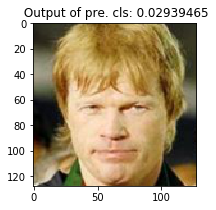

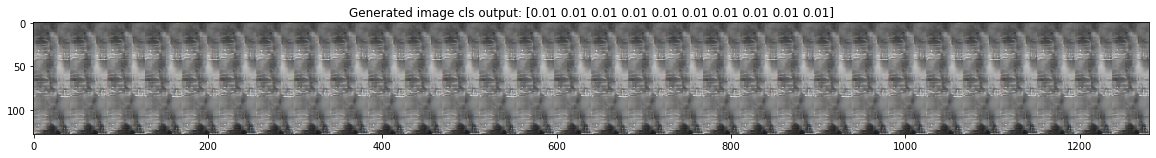

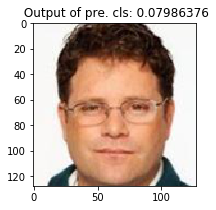

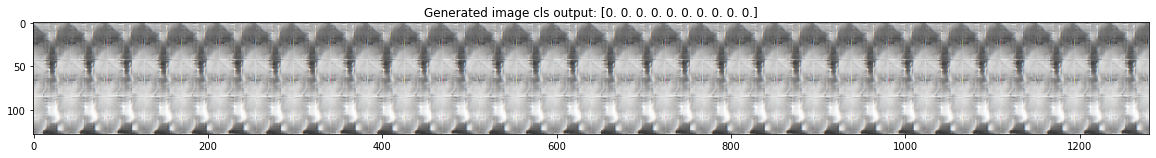

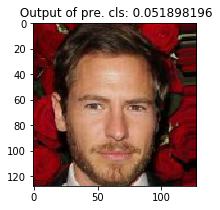

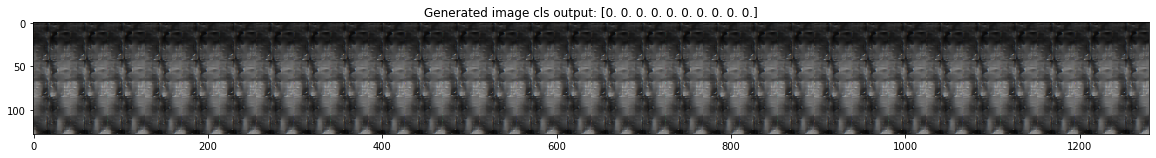

IndexError: index 3 is out of bounds for axis 0 with size 3

<Figure size 216x216 with 0 Axes>

In [37]:
view(real_img[0:3], 10, real_prediction[0:30], fake_img[0:30], fake_prediction[0:30])